# Training notebook

This notebook will take you through all the steps to train a CNN classifier, the first step in a CODEX analysis. Follow the cells in order, modify them where needed and run them all. Hints and defaults values are suggested. Follow the training curves with Tensorboard to check whether you are satisfied with the model (good classification performance, moderated overfitting). You will probably have to give it a couple of runs before being fully satisfied. Keep in mind that the training will be orders of magnitude faster on GPU compared to CPU. If Pytorch and CUDA were properly set, the notebook will run on GPU without additional input from you.

## Import libraries

Make sure to import model class, dataset class and the required preprocessing operations (RandomCrop, ToTensor, Subtract...).

In [1]:
# Standard libraries
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
import datetime
from tensorboardX import SummaryWriter
import os
import zipfile
import time
import seaborn as sns
import pandas as pd
import warnings
import sys

# Custom functions/classes
path_to_module = '../source'  # Path where all the .py files are, relative to the notebook folder
sys.path.append(path_to_module)
from load_data import DataProcesser
from train_utils import accuracy, AverageMeter
from models import ConvNetCam, ConvNetCamBi
from class_dataset import myDataset, ToTensor, Subtract, RandomShift, RandomNoise, RandomCrop, FixedCrop

# For reproducibility
myseed = 7
torch.manual_seed(myseed)
torch.cuda.manual_seed(myseed)
np.random.seed(myseed)

## Hyperparameters for training

Hyperparameters for training:
- nepochs: int, number of training epochs.
- batch_size: int, number of samples per batch.
- lr: float, initial learning rate. This is the most important parameter to tweak to have a smooth learning curve. 1e-2 is usually a good starting value.
- L2_reg: float, L2 regularization factor. This helps to prevent overfitting by penalizing large weights in the model parameters. In general try to always have a mild regularization, say 1e-3. Increase if you face overfitting issues.

Hyperparameters to set the model dimensions:
- length: int, length of a trajectory. This is the input length as the model will expect it. Setting it to a smaller value than the actual length of the trajectories can be used for data augmentation (see RandomCrop).
- nclass: int, number of output classes.
- nfeatures: int, size of the input representation before the output layer. This also corresponds to the number of filters in the last convolution layer.
- selected_classes: list, select only some classes from input dataset. Leave an empty list to use all classes.

In [2]:
nepochs = 15
batch_size = 256
lr = 1e-2
L2_reg = 1e-3

length = 750
nclass = 2
nfeatures = 10
selected_classes = []

## Load and process data, Data augmentation

Define which data to load and whether/how to preprocess the batch. 
- data_file: str, path to a .zip that can be loaded as a DataProcesser. The zip archive must contain 3 files: one for the
 data (dataset.csv), one for the split train/validation/test (id_set.csv), one with the classes informations (classes.csv). See DataProcesser.read_archive() for format details.
- meas_var: list of str or None, names of the measurement variables. In DataProcesser convention, this is the prefix in a
 column name that contains a measurement (time being the suffix). Pay attention to the order since this is how the dimensions of a sample of data will be ordered (i.e. 1st in the list will form 1st row of measurements in the sample, 2nd is the 2nd, etc...) If None, DataProcesser will extract automatically the measurement names and use the order of appearance in the column names.
- start_time/end_time: int or None, use to subset data to a specific time range. If None, DataProcesser will extract automatically the range of time in the dataset columns. Useful to completely exclude some acquisition times where irrelevant measures are acquired.

In [3]:
data_file = '../sample_data/Synthetic_Univariate.zip'

meas_var = None
start_time = None
end_time = None

In [4]:
data = DataProcesser(data_file)

# Select measurements and times, subset classes and split the dataset
meas_var = data.detect_groups_times()['groups'] if meas_var is None else meas_var
start_time = data.detect_groups_times()['times'][0] if start_time is None else start_time
end_time = data.detect_groups_times()['times'][1] if end_time is None else end_time
data.subset(sel_groups=meas_var, start_time=start_time, end_time=end_time)
if selected_classes:
    data.dataset = data.dataset[data.dataset[data.col_class].isin(selected_classes)]
data.get_stats()
data.split_sets()

# Input preprocessing, this is done sequentially, on the fly when the input is passed to the network
average_perChannel = [data.stats['mu'][meas]['train'] for meas in meas_var]
ls_transforms = transforms.Compose([
    RandomCrop(output_size=length, ignore_na_tails=True),
    Subtract(average_perChannel),
    ToTensor()])

# Define the dataset objects that associate data to preprocessing and define the content of a batch
# A batch of myDataset contains: the trajectories, the trajectories identifier and the trajecotires class identifier
data_train = myDataset(dataset=data.train_set, transform=ls_transforms)
data_test = myDataset(dataset=data.validation_set, transform=ls_transforms)

# Quick recap of the data content
print('Channels order: {} \nTime range: ({}, {}) \nClasses: {}'.format(meas_var, start_time, end_time, list(data.dataset[data.col_class].unique())))
if nclass != len(list(data.dataset[data.col_class].unique())):
    warnings.warn('The number of classes in the model output is not equal to the number of classes in the data.')

../source\load_data.py:88: UserWarning: datatable module not found, using pandas instead. To prevent this message from appearing use "datatable = False" when reading the archive.
  warnings.warn('datatable module not found, using pandas instead. To prevent this message from appearing'


Channels order: ['FRST'] 
Time range: (0, 749) 
Classes: [0, 1]


../source\load_data.py:473: UserWarning: Data were not processed.
  warnings.warn('Data were not processed.')


Plot some trajectories to check that the data loading and preprocessing is properly done. The curves appear here as they will be presented to the CNN.

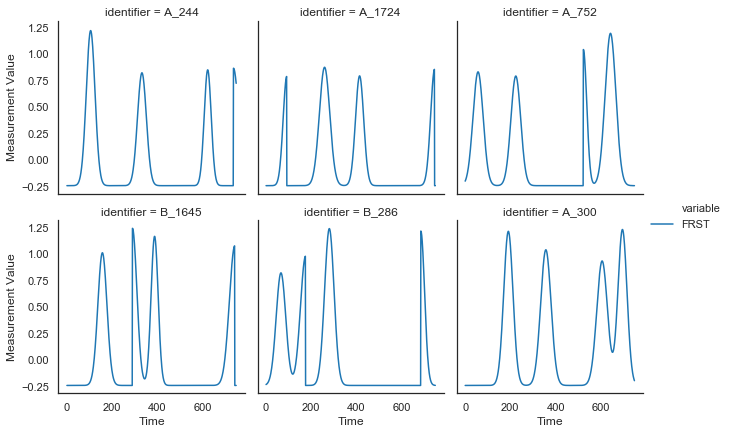

In [5]:
n_smpl = 6
indx_smpl = np.random.randint(0, len(data_train), n_smpl)

col_ids = []
col_lab = []
col_mes = []
# Long format for seaborn grid, for loop to avoid multiple indexing
# This would triggers preprocessing multiple times and add randomness
for i in indx_smpl:
    smpl = data_train[i]
    col_ids.append(smpl['identifier'])
    col_lab.append(smpl['label'].item())
    col_mes.append(smpl['series'].numpy().transpose())
col_ids = pd.Series(np.hstack(np.repeat(col_ids, length)))
col_lab = pd.Series(np.hstack(np.repeat(col_lab, length)))
col_mes = pd.DataFrame(np.vstack(col_mes), columns=meas_var)
col_tim = pd.Series(np.tile(np.arange(0, length), n_smpl))

df_smpl = pd.concat([col_ids, col_lab, col_tim, col_mes], axis=1)
df_smpl.rename(columns={0: 'identifier', 1: 'label', 2:'time'}, inplace=True)
df_smpl = df_smpl.melt(id_vars=['identifier', 'label', 'time'], value_vars=meas_var)

sns.set_style('white')
sns.set_context('notebook')
grid = sns.FacetGrid(data=df_smpl, col='identifier', col_wrap=3, sharex=True)
grid.map_dataframe(sns.lineplot, x='time', y='value', hue='variable')
grid.set(xlabel='Time', ylabel='Measurement Value')
grid.add_legend()

## Resume training or new model

Set to None for a new model, otherwise provide the path to a saved model file. 

In [6]:
load_model = None
# load_model = 'path/to/file.pytorch'

## Tensorboard logs and model save file

Define where the directory where training logs will be saved and the file where the model will be saved. By default, creates two subdirectories in the working directory: models and logs. An unique name for the logs and the model is created by appending the measurement name to the current timestamp.

The model training can be monitored in real-time in Tensorboard with these logs.

In [7]:
file_logs = os.path.splitext(os.path.basename(data_file))[0]  # file name without extension
logs_str = 'logs/' + '_'.join(meas_var) + '/' + datetime.datetime.now().strftime('%Y-%m-%d-%H__%M__%S') + \
           '_' + file_logs + '/'
writer = SummaryWriter(logs_str)
save_model = 'models/' + logs_str.lstrip('logs/').rstrip('/') + '.pytorch'

if not os.path.exists('models/' + '_'.join(meas_var)):
    os.makedirs('models/' + '_'.join(meas_var))

## Setup model, loss and optimizer

Create the model object and gives it dimensions that fit the previous parameters (length of the input, size of the latent representation...).

The loss (called criterion in pytorch convention) against which the model is trained is defined here. For regular classification tasks use the CrossEntropyLoss. All available options are listed here: https://pytorch.org/docs/1.1.0/nn.html#loss-functions

The optimizer defines which algorithm is used to update the weights of the model through the training. L2 regularization is controlled by the "weight_decay" argument in the optimizer object. Adam optimizer with default parameters is a good default. All available options are listed here: https://pytorch.org/docs/1.1.0/optim.html#algorithms

Scheduler defines how the learning rate should evolve through the training. In order to get a smooth training and better classification performance, it needs to be reduced after some epochs. One of the easiest scheduler is the MultiStepLR which reduces the learning rate by a factor gamma when milestone epochs are reached. To start, just try to divide the learning rate by a factor 0.1, 3-4 times through the training. All available options are listed here: https://pytorch.org/docs/1.1.0/optim.html#how-to-adjust-learning-rate

In [8]:
model = ConvNetCam(batch_size=batch_size, nclass=nclass, length=length, nfeatures=nfeatures)
# model = ConvNetCamBi(batch_size=batch_size, nclass=nclass, length=length, nfeatures=nfeatures)  # for bivariate input
if load_model:
    model.load_state_dict(torch.load(load_model))
model.double()
cuda_available = torch.cuda.is_available()
if cuda_available:
    model = model.cuda()
    
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=L2_reg)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8, 12], gamma=0.1)

## Training loop

Training of the model, you probably won't have anything to change here.

In [9]:
def TrainModel(model, optimizer, criterion, scheduler, train_loader, test_loader, nepochs,
               save_model=save_model, logs=True):
    # ------------------------------------------------------------------------------------------------------------------
    # Model, loss, optimizer
    top1 = AverageMeter()
    top2 = AverageMeter()

    if logs:
        print('Train logs saved at: {}'.format(logs_str))

    # ------------------------------------------------------------------------------------------------------------------
    # Get adequate size of sample for nn.Conv layers
    # Add a dummy channel dimension for conv1D layer (if multivariate, treat as a 2D plane with 1 channel)
    assert len(train_loader.dataset[0]['series'].shape) == 2
    nchannel, univar_length = train_loader.dataset[0]['series'].shape
    if nchannel == 1:
        view_size = (batch_size, 1, univar_length)
    elif nchannel >= 2:
        view_size = (batch_size, 1, nchannel, univar_length)

    # ------------------------------------------------------------------------------------------------------------------
    # Training loop
    for epoch in range(nepochs):
        model.train()
        top1.reset()
        top2.reset()

        loss_train = []
        for i_batch, sample_batch in enumerate(train_loader):
            series, label = sample_batch['series'], sample_batch['label']
            if cuda_available:
                series, label = series.cuda(), label.cuda()
            series = series.view(view_size)
            prediction = model(series)
            #################################################
            # Todo: Check if always necessary
            label = label.type(torch.LongTensor)
            label = label.cuda()
            #################################################
            loss = criterion(prediction, label)
            loss_train.append(loss.cpu().detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i_batch % 25 == 0:
                print('Training epoch: [{0}/{4}][{1}/{2}]; Loss: {3}'.format(epoch + 1, i_batch + 1, len(train_loader),
                                                                             loss, nepochs))

            prec1, prec2 = accuracy(prediction, label, topk=(1, 2))
            top1.update(prec1[0], series.size(0))
            top2.update(prec2[0], series.size(0))

            if i_batch % 100 == 0:
                print('Training Accuracy Epoch: [{0}]\t'
                      'Prec@1 {top1.val.data:.3f} ({top1.avg.data:.3f})\t'
                      'Prec@2 {top2.val.data:.3f} ({top2.avg.data:.3f})'.format(
                    epoch, top1=top1, top2=top2))
            if logs:
                writer.add_scalar('Train/Loss', loss, epoch * len(train_loader) + i_batch + 1)
                writer.add_scalar('Train/Top1', top1.val, epoch * len(train_loader) + i_batch + 1)
                writer.add_scalar('Train/Top2', top2.val, epoch * len(train_loader) + i_batch + 1)
        if logs:
            writer.add_scalar('MeanEpoch/Train_Loss', np.mean(loss_train), epoch)
            writer.add_scalar('MeanEpoch/Train_Top1', top1.avg, epoch)
            writer.add_scalar('MeanEpoch/Train_Top2', top2.avg, epoch)

        # --------------------------------------------------------------------------------------------------------------
        # Evaluation loop
        model.eval()
        top1.reset()
        top2.reset()
        loss_eval = []
        for i_batch, sample_batch in enumerate(test_loader):
            series, label = sample_batch['series'], sample_batch['label']
            if cuda_available:
                series, label = series.cuda(), label.cuda()
            series = series.view(view_size)
            #################################################
            # Todo: Check if always necessary
            label = label.type(torch.LongTensor)
            label = label.cuda()
            #################################################
            label = torch.autograd.Variable(label)
            
            prediction = model(series)
            loss = criterion(prediction, label)
            loss_eval.append(loss.cpu().detach().numpy())

            prec1, prec2 = accuracy(prediction, label, topk=(1, 2))
            top1.update(prec1[0], series.size(0))
            top2.update(prec2[0], series.size(0))

        # For validation loss, report only after the whole batch is processed
        if logs:
            writer.add_scalar('Val/Loss', loss, epoch * len(train_loader) + i_batch + 1)
            writer.add_scalar('Val/Top1', top1.val, epoch * len(train_loader) + i_batch + 1)
            writer.add_scalar('Val/Top2', top2.val, epoch * len(train_loader) + i_batch + 1)
            writer.add_scalar('MeanEpoch/Val_Loss', np.mean(loss_eval), epoch)
            writer.add_scalar('MeanEpoch/Val_Top1', top1.avg, epoch)
            writer.add_scalar('MeanEpoch/Val_Top2', top2.avg, epoch)


        print('===>>>\t'
              'Prec@1 ({top1.avg.data:.3f})\t'
              'Prec@2 ({top2.avg.data:.3f})'.format(top1=top1, top2=top2))

        writer.add_scalar('LearningRate', optimizer.param_groups[0]['lr'], epoch)
        scheduler.step()
        
        
    if save_model:
        torch.save(model, save_model)
        print('Model saved at: {}'.format(save_model))
    return model


## Train the model

Can follow the training in tensorboard with:
```
tensorboard --logdir "path/to/logs"
```

In [10]:
train_loader = DataLoader(dataset=data_train,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          drop_last=True)
test_loader = DataLoader(dataset=data_test,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=4,
                         drop_last=True)

t0 = time.time()
mymodel = TrainModel(model, optimizer, criterion, scheduler, train_loader, test_loader, nepochs)
t1 = time.time()

print('Elapsed time: {:.2f} min'.format((t1 - t0)/60))

Train logs saved at: logs/FRST/2020-07-30-18__47__06_Synthetic_Univariate/
Training epoch: [1/15][1/11]; Loss: 0.688093128173594
Training Accuracy Epoch: [0]	Prec@1 49.219 (49.219)	Prec@2 100.000 (100.000)
===>>>	Prec@1 (52.083)	Prec@2 (100.000)
Training epoch: [2/15][1/11]; Loss: 0.6155195810946633
Training Accuracy Epoch: [1]	Prec@1 83.984 (83.984)	Prec@2 100.000 (100.000)
===>>>	Prec@1 (49.479)	Prec@2 (100.000)
Training epoch: [3/15][1/11]; Loss: 0.5349754286742658
Training Accuracy Epoch: [2]	Prec@1 84.766 (84.766)	Prec@2 100.000 (100.000)
===>>>	Prec@1 (49.870)	Prec@2 (100.000)
Training epoch: [4/15][1/11]; Loss: 0.4230174374782543
Training Accuracy Epoch: [3]	Prec@1 84.766 (84.766)	Prec@2 100.000 (100.000)
===>>>	Prec@1 (50.130)	Prec@2 (100.000)
Training epoch: [5/15][1/11]; Loss: 0.38424354232966007
Training Accuracy Epoch: [4]	Prec@1 81.250 (81.250)	Prec@2 100.000 (100.000)
===>>>	Prec@1 (51.042)	Prec@2 (100.000)
Training epoch: [6/15][1/11]; Loss: 0.3545265487019744
Training A

## What's next

- Make sure that you are satisfied with the model. A quick way to do this is to check the Tensorboard logs. Check in priority if the classification performance are good enough (top1/top2 indicators) and that there is no serious problems of overfitting (difference between the training and validation sets should remain reasonably small).
- When possible, try to play around with the parameters before deciding on a given model. In priority, try to tweak the initial learning rate by a few orders of magnitude and the learning rate scheduler to see if you can get a smoothly converging training curve. If your model is overfitting try to reduce the number of features or to increase the L2 regularization strength.
- When you are satisfied with the model, you can go on the next notebooks to identify prototype trajectories and to identify class-discriminative motifs with CAMs.
- Alternatively, you can use the companion app to browse an interactive projection of the CNN features.